###### <img src="./logo_UTN.svg" align="right" width="150" /> 

### Procesamiento Digital de Señales

## Trabajo Práctico Nº10: Procesamiento no lineal de ECG (2da parte).

### Gabriel Cruz

## Enunciado

#### Realizar el punto 5 del TP4.

5 ) Utilice las siguientes metodologías no lineales de estimación-substracción para la remoción de la interferencia de línea de base, y compare con las técnicas lineales del punto anterior en las mismas regiones. Luego discuta las ventajas y desventajas de cada técnica.

a) Estimación del movimiento de línea de base a partir del filtrado de mediana. A partir de la siguiente estimación del movimiento de línea de base

\begin{equation}
\hat{b} = med_{600} (med_{200} (s))
\end{equation}

Donde s representa la señal de ECG a partir de la que estimamos el movimiento de la línea de base b^. El operador med200 calcula muestra a muestra la mediana en los 200 ms previos a la muestra actual. Luego dicha estimación la substraemos para estimar la actividad eléctrica cardíaca x^

\begin{equation}
\hat{x} = s - \hat{b}
\end{equation}

##### Ayuda: Puede utilizar la implementación del filtro de mediana provista en scipy.signal

b) Estimación del movimiento de línea de base a partir de los segmentos isoeléctricos de cada latido. A partir de las detecciones provistas, puede estimar aproximadamente el nivel isoeléctrico, es decir el momento donde la actividad eléctrica cardíaca es nula. El intervalo entre la onda P y Q, es un buen momento para estimar las características de las señales interferentes que originan el movimiento de la línea de base.

Para la localización del segmento PQ puede valerse de la localización de cada latido (líneas rojas verticales) y a partir de la misma, anticipar un tiempo adecuado de manera tal de no incluir la onda P ni Q. Puede ayudarse con el latido promedio de un latido normal para establecer dicho intervalo.

Recuerde que la señal de línea de base debe estar muestreada a la misma frecuencia que el ECG, por lo que debería remuestrear dicha señal (puede usar la función de interpolación spline para ello).

##### Ayuda: Puede utilizar la función de interpolación spline scipy.interpolate.CubicSpline


## a) Estimación del movimiento de línea de base a partir del filtrado de mediana

In [1]:
import numpy as np
from scipy import signal as sig

import matplotlib.pyplot as plt

import scipy.io as sio
from scipy.io.wavfile import write

from scipy import signal
from scipy.fft import fft, fftshift
from scipy.interpolate import CubicSpline

def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

In [2]:
###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

fs = 1000 # Hz
nyq_frec = fs / 2

mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

ecg_interes = ecg_one_lead[4000:5500] #10 segundo de la señal ECG
N = len(ecg_interes)

ecg_interes2 = ecg_one_lead[900000:903000]


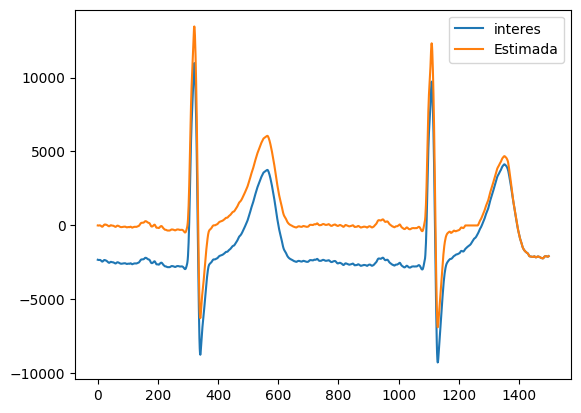

In [6]:
#%%a) Estimación del movimiento de línea de base a partir del filtrado de mediana
kernel_1 = 199 # No deja valores pares
kernel_2 = 599 # No deja valores pares

est_1 = sig.medfilt(ecg_interes, kernel_1)

est_2 = sig.medfilt(est_1, kernel_2)

AEC = ecg_interes - est_2

plt.figure()
plt.plot(ecg_interes, label = 'interes')
plt.plot(AEC, label='Estimada')
plt.legend()
plt.show()

En el grafico de arriba se puede observar el metodo de filtrado de mediana. Este metodo no lineal es mucho mejor para eliminar las interferencias en el segmento entre P y Q, comparandolo con los filtro lineales que no eran eficientes para eliminar estas interferencias, una desventaja que tiene este metodo es que requiere de un mayor procesamiento computacional ya que esta realizando la mediana en segmentos y si la señal es muy grande puede demandar mayor procesamiento.

## Filtrado por Interpolacion con CubicSpline

In [9]:
#%% b) Estimación del movimiento de línea de base a partir de los segmentos isoeléctricos de cada latido. 

ventana = 600
R_i_inf = 250
R_i_sup = 350

ecg_one_lead = np.ravel(ecg_one_lead)
qrs_detecion = mat_struct['qrs_detections']
N_det = len(qrs_detecion)

matriz_ecg_ventanas = np.zeros((ventana,N_det))

for i in range(N_det):
    matriz_ecg_ventanas[:,i] = ecg_one_lead[int(qrs_detecion[i]-R_i_inf) : int(qrs_detecion[i] + R_i_sup)]
    matriz_ecg_ventanas[:,i] = matriz_ecg_ventanas[:,i] - np.mean(matriz_ecg_ventanas[:,i])
   
    
Num_latido_interes = 1545  # Los busque en el explorador de variables para que conincida con la señal de 900000 a 903000
Num_latido_interes_2 = 1550
Num_latidos = Num_latido_interes_2 - Num_latido_interes

matriz_interes = matriz_ecg_ventanas[:,Num_latido_interes:Num_latido_interes_2]

C:\Users\gabri\AppData\Local\Temp\ipykernel_13572\2156544836.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matriz_ecg_ventanas[:,i] = ecg_one_lead[int(qrs_detecion[i]-R_i_inf) : int(qrs_detecion[i] + R_i_sup)]


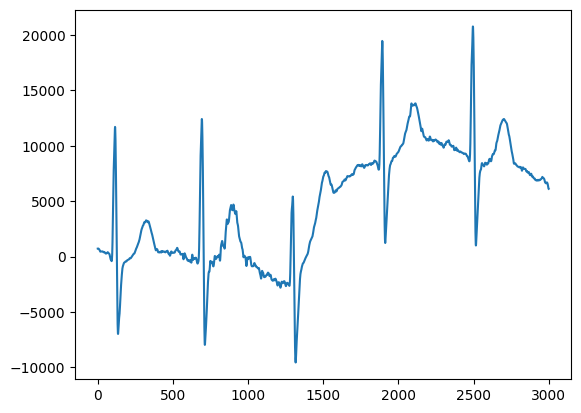

In [10]:
plt.figure()
plt.plot(ecg_interes2)

En el grafico de arriba se puede observar un segmento de la señal ECG para realizar el analisis del filtrado por interpolacion.

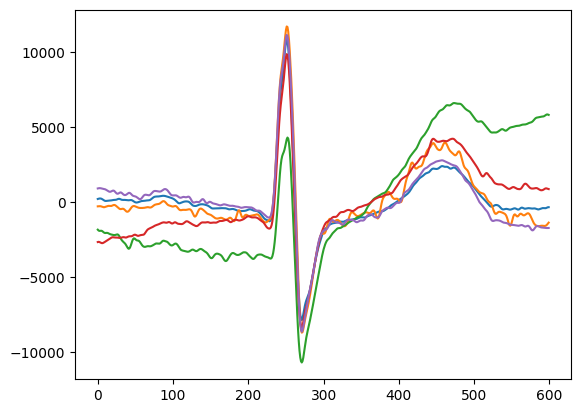

In [11]:
plt.figure()
plt.plot(matriz_interes)

En el grafico de arriba se puede obsevar la deteccion del picos QRS, el cual es necesario para analizar el segmento entre P y Q. Este es el momento para estimar las interferencias. Se va a analizar 70ms antes del pico QRS hasta el pico QRS.

C:\Users\gabri\AppData\Local\Temp\ipykernel_13572\878671444.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Valor_x[i] = int(qrs_detecion[i + Num_latido_interes] - intervalo_PQ_ms)
C:\Users\gabri\AppData\Local\Temp\ipykernel_13572\878671444.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Valor_x2[i] = int(qrs_detecion[i + Num_latido_interes])


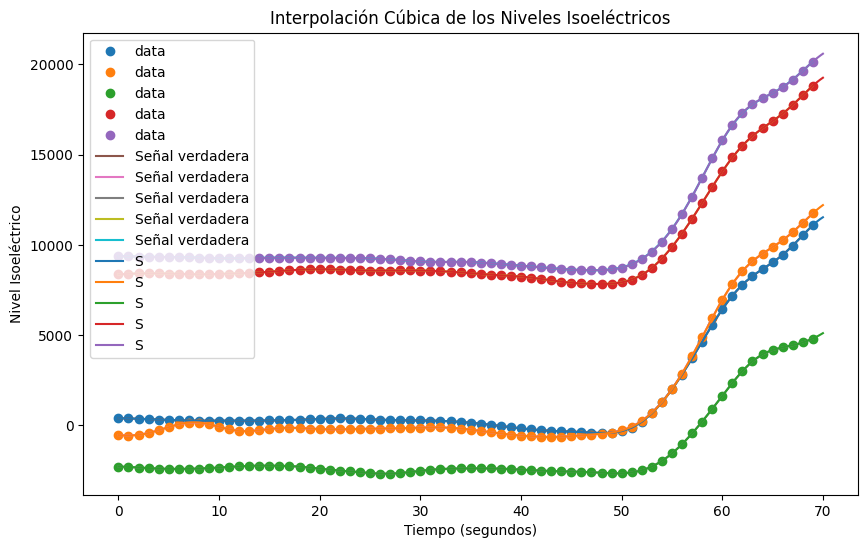

In [13]:
intervalo_PQ_ms = 70 #anticipo unos 70ms para estar entre P y Q. Valor obtenido por latido promedio

Valor_x = np.zeros(Num_latidos) 
Valor_x2 = np.zeros(Num_latidos) 

for i in range(Num_latidos):
    Valor_x[i] = int(qrs_detecion[i + Num_latido_interes] - intervalo_PQ_ms)
    Valor_x2[i] = int(qrs_detecion[i + Num_latido_interes])

nivel_isoelectrico = np.zeros((intervalo_PQ_ms,Num_latidos))

for i in range (Num_latidos):
    nivel_isoelectrico[:,i] = ecg_one_lead[int(Valor_x[i]):int(Valor_x2[i])]

# plt.figure()
# plt.plot(nivel_isoelectrico)

#%% Interpolacion con CubicSpline
num_muestras = 70

x = np.arange(num_muestras)
y = nivel_isoelectrico  
cs = CubicSpline(x, y)

xs = np.arange(0, num_muestras, 1/fs)

# Graficar el resultado
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='data')
plt.plot(x, y, label='Señal verdadera')
plt.plot(xs, cs(xs), label="S")
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Nivel Isoeléctrico')
plt.legend()
plt.title('Interpolación Cúbica de los Niveles Isoeléctricos')
plt.show()

En el grafico de arriba se puede ver la zona de interes realizando las interpolaciones en cada segmento entre P y Q.

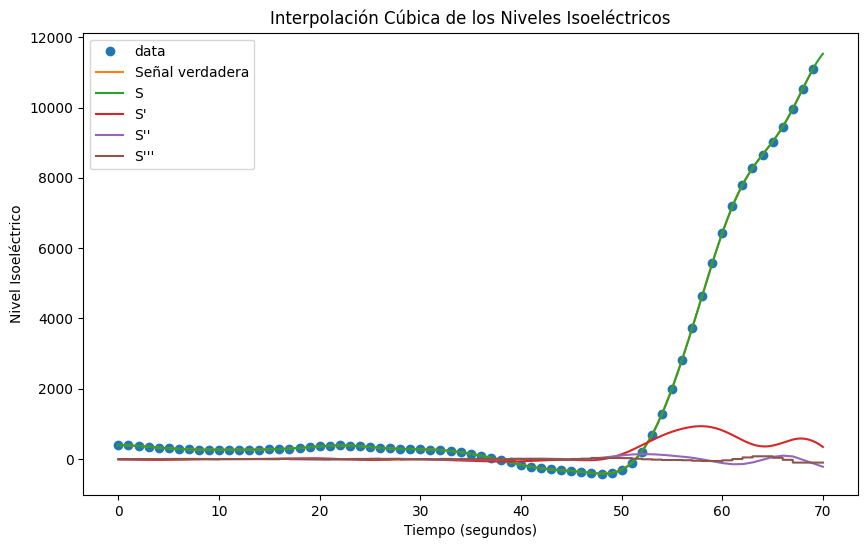

In [19]:

x = np.arange(num_muestras)
y = nivel_isoelectrico[:,0]  
cs = CubicSpline(x, y)

xs = np.arange(0, num_muestras, 1/fs)

# Graficar el resultado
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='data')
plt.plot(x, y, label='Señal verdadera')
plt.plot(xs, cs(xs), label="S")
plt.plot(xs, cs(xs, 1), label="S'")
plt.plot(xs, cs(xs, 2), label="S''")
plt.plot(xs, cs(xs, 3), label="S'''")
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Nivel Isoeléctrico')
plt.legend()
plt.title('Interpolación Cúbica de los Niveles Isoeléctricos')
plt.show()

En la grafica de arriba se puede ver la interpolacion del primer segmento PQ y la propiedad de continuidad que se mantiene la primera, segunda y tercera derivada.